In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from matplotlib.font_manager import FontProperties
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*findfont: Font family \['sans-serif'\] not found.*")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']  # Add other fonts if needed

In [3]:
format_plots()
#format_pizza_plots()
c = PlotConfig()
saver = save_factory(c.dana_save_path / "wheel", tight_layout=False)

'''
fig = figure(1.2, 1)
sns.despine()
# saver(fig, 'velocity-vs-age');
# saver(fig, 'scalars-vs-age', tight_layout=True);

fig, ax = plt.subplots(2, 2, figsize=(3.5, 2), sharex=True)

for key, a in zip(scalar_keys, ax.flat):
    scalar_key = key.split("_")[0] if 'height' in key else key.split('_')[1]
    a = sns.lineplot(
        data=scalars,
        x="age",
        y=key,
        color="k",
        err_kws=dict(lw=0),
        ax=a,
        errorbar=("sd"),
        label="Raw",
    )
    a = sns.lineplot(
        data=scalars,
        x="age",
        y=f'recon_{scalar_key}',
        color="darkgreen",
        err_kws=dict(lw=0),
        errorbar="sd",
        ax=a,
        label="Reconstructed",
    )
    a.legend_.remove()
'''

'\nfig = figure(1.2, 1)\nsns.despine()\n# saver(fig, \'velocity-vs-age\');\n# saver(fig, \'scalars-vs-age\', tight_layout=True);\n\nfig, ax = plt.subplots(2, 2, figsize=(3.5, 2), sharex=True)\n\nfor key, a in zip(scalar_keys, ax.flat):\n    scalar_key = key.split("_")[0] if \'height\' in key else key.split(\'_\')[1]\n    a = sns.lineplot(\n        data=scalars,\n        x="age",\n        y=key,\n        color="k",\n        err_kws=dict(lw=0),\n        ax=a,\n        errorbar=("sd"),\n        label="Raw",\n    )\n    a = sns.lineplot(\n        data=scalars,\n        x="age",\n        y=f\'recon_{scalar_key}\',\n        color="darkgreen",\n        err_kws=dict(lw=0),\n        errorbar="sd",\n        ax=a,\n        label="Reconstructed",\n    )\n    a.legend_.remove()\n'

In [4]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_08/wheel_clean.parquet')
df = pd.read_parquet(path)

In [5]:
col=['age', 'mouse', 'cage', 'uuid', 'subject_name', 'date','rotations',
       'cum_rotations_x', 'cum_rotations_y', 'exp']

In [6]:
## update data
def remove_crl(df):
    max=75
    df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

def remove_crl_wheel(df):
    max=75
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df

In [7]:
# arrange data
# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age','pseudo_age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd['remapped_bins'] = m_psd['pseudo_age']
m_psd.set_index(['remapped_bins'], 
                append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

In [8]:
# pseudo regression
mdl = KNeighborsRegressor(n_neighbors=10)
x = m_psd.copy()
y = x.index.get_level_values('remapped_bins')
x = x.filter(regex=r'\d')
mdl.fit(x, y)
print(mdl.score(x, y))

0.9797606636282236


In [9]:
# apply to wheel data
#x = df.drop(['age', 'mouse', 'cage', 'uuid', 'subject_name', 'date','rotations',
#       'cum_rotations_x', 'cum_rotations_y', 'exp'],axis=1)
w_psd = df.copy()
w_psd = remove_crl_wheel(w_psd)
x = w_psd.filter(regex=r'\d')
#if you want to log transform
#x = np.log(x + 1e-6) # convert to linear
w_psd['remapped_bins']=mdl.predict(x)

In [10]:
import math
w_psd= w_psd.reset_index()
w_psd['age_wk']=(w_psd['age'] / 7).round().astype(int)

In [11]:
w_psd['exp'] = w_psd['cage'].str[:3]

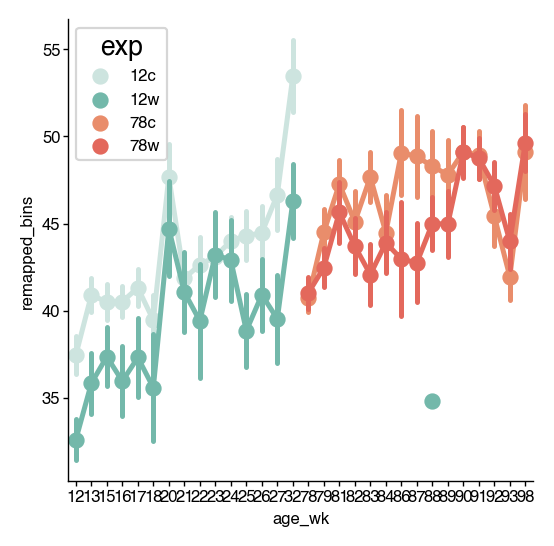

In [12]:
sns.pointplot(
    data=w_psd,
    x="age_wk",
    y="remapped_bins",
    palette = ['#cde4df','#73b8aa','#e98d6b', '#e3685c'],
    estimator='mean',
    errorbar='se',
    hue="exp")
sns.despine()

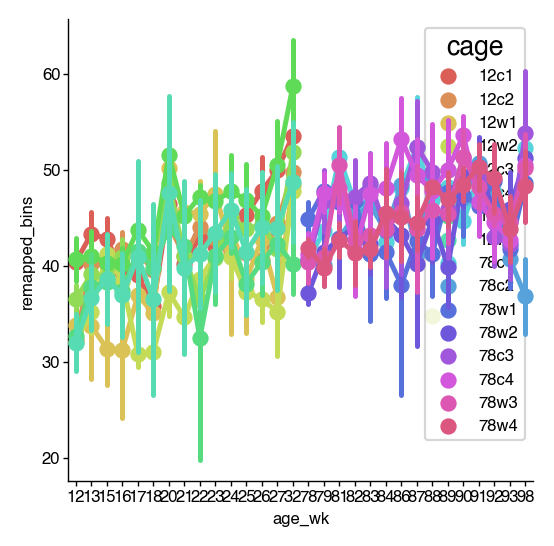

In [13]:
sns.pointplot(
    data=w_psd,
    x="age_wk",
    y="remapped_bins",
    palette = "hls",
    estimator='mean',
    errorbar='se',
    hue="cage")
sns.despine()

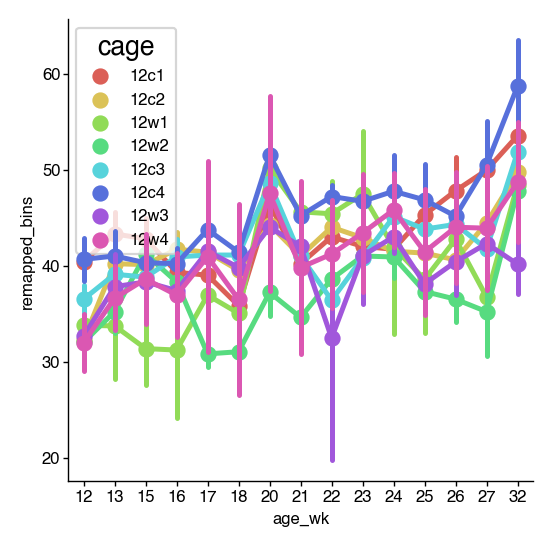

In [14]:
sns.pointplot(
    data=w_psd.query("age_wk<70"),
    x="age_wk",
    y="remapped_bins",
    palette = "hls",
    estimator='mean',
    errorbar='se',
    hue="cage")
sns.despine()

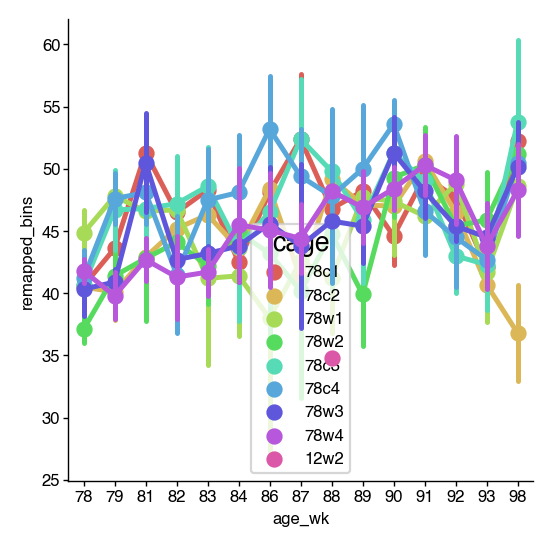

In [15]:
sns.pointplot(
    data=w_psd.query("age_wk>70"),
    x="age_wk",
    y="remapped_bins",
    palette = "hls",
    estimator='mean',
    errorbar='se',
    hue="cage")
sns.despine()

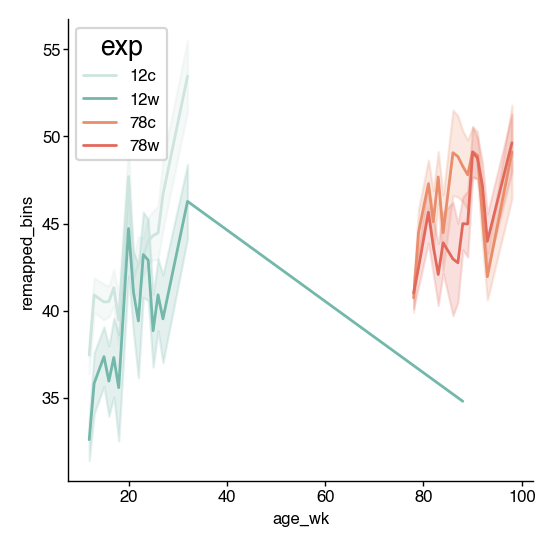

In [16]:
sns.lineplot(
    data=w_psd,
    x="age_wk",
    y="remapped_bins",
    palette = ['#cde4df','#73b8aa','#e98d6b', '#e3685c'],
    estimator='mean',
    errorbar='se',
    hue="exp")
sns.despine()

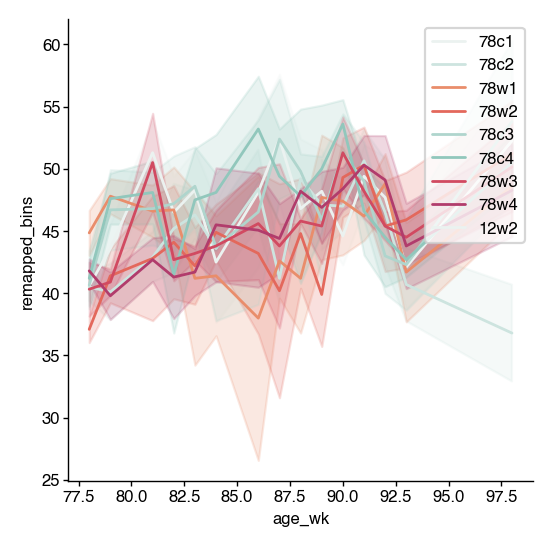

In [17]:
sns.lineplot(
    data=w_psd.query('age_wk>60'),
    x="age_wk",
    y="remapped_bins",
    palette = ['#ebf2f0', '#cde4df','#e98d6b', '#e3685c','#afd5cd', '#91c7bc','#d14a61', '#b13c6c'],
    estimator='mean',
    errorbar='se',
    hue="cage")
legend=plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
sns.despine()

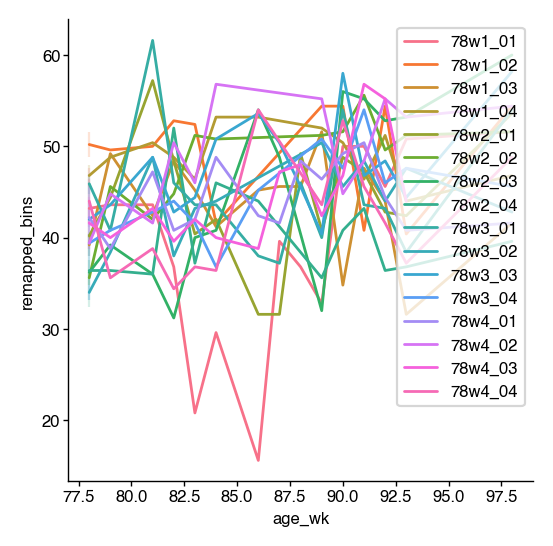

In [18]:
sns.lineplot(
    data=w_psd.query(("age_wk>60 and exp=='78w'")),
    x="age_wk",
    y="remapped_bins",
    #palette = ['#ebf2f0', '#cde4df','#e98d6b', '#e3685c','#afd5cd', '#91c7bc','#d14a61', '#b13c6c'],
    estimator='mean',
    errorbar='se',
    hue="mouse")
legend=plt.legend(loc='upper right', bbox_to_anchor=(1, 1))   
sns.despine()

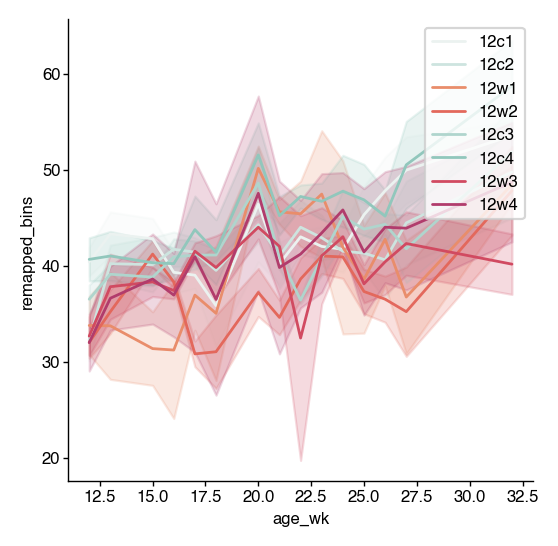

In [19]:
sns.lineplot(
    data=w_psd.query('age_wk<60'),
    x="age_wk",
    y="remapped_bins",
    palette = ['#ebf2f0', '#cde4df','#e98d6b', '#e3685c','#afd5cd', '#91c7bc','#d14a61', '#b13c6c'],
    estimator='mean',
    errorbar='se',
    hue="cage")
legend=plt.legend(loc='upper right', bbox_to_anchor=(1, 1))    
sns.despine()

In [20]:
# calcualte absolute diff in psd between begining and end of exp
psd_diff = w_psd.groupby(['mouse','cage','exp']).apply(lambda group: group.loc[group['age_wk'].idxmax()]["remapped_bins"] - group.loc[group['age_wk'].idxmin()]["remapped_bins"])
psd_diff = psd_diff.reset_index()
psd_diff.columns = ['mouse','cage','exp','diff']

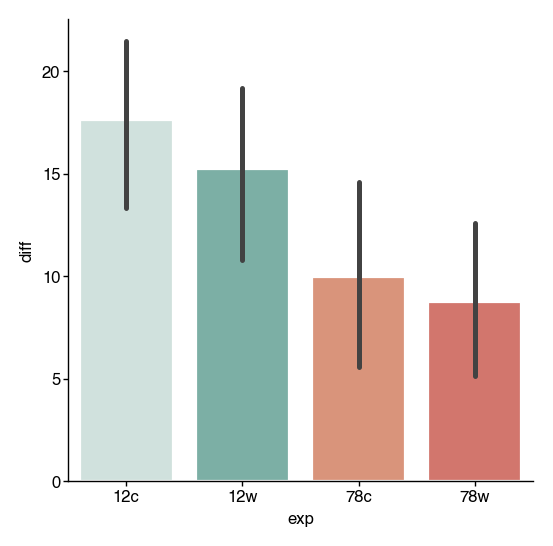

In [21]:
sns.barplot(
    data=psd_diff, 
    x="exp", 
    palette = ['#cde4df','#73b8aa','#e98d6b', '#e3685c'],
    y="diff")
sns.despine()

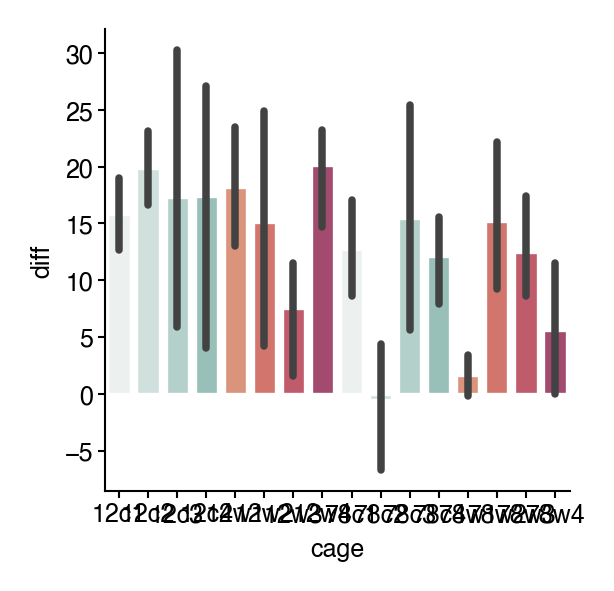

In [22]:
figure(2,2)
sns.barplot(
    data=psd_diff, 
    x="cage", 
    palette = ['#ebf2f0', '#cde4df','#afd5cd', '#91c7bc','#e98d6b', '#e3685c','#d14a61', '#b13c6c','#ebf2f0', '#cde4df','#afd5cd', '#91c7bc','#e98d6b', '#e3685c','#d14a61', '#b13c6c'],
    y="diff")
sns.despine()